In [1]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set_style("darkgrid")
from sklearn import linear_model
import random
import math
import os

import warnings
warnings.filterwarnings('ignore')


/usr/lib/python3/dist-packages/matplotlib/__init__.py:874: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Decripcion de los datos
             year        temp
count   133.00000  133.000000
mean   1946.00000    8.528271
std      38.53786    0.629293
min    1880.00000    6.920000
25%    1913.00000    8.100000
50%    1946.00000    8.430000
75%    1979.00000    8.890000
max    2012.00000   10.410000

Las primeras 8 filas de los datdos
   year  temp
0  1880  7.79
1  1881  8.19
2  1882  8.49
3  1883  7.94
4  1884  7.60
5  1885  8.16
6  1886  7.67
7  1887  8.23


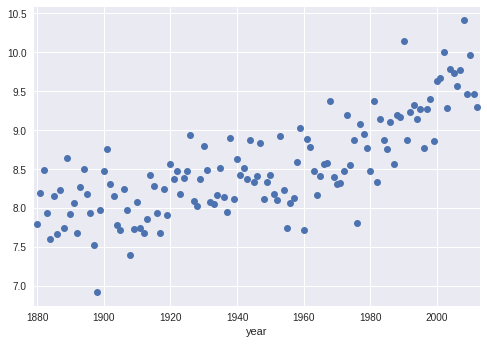

In [46]:
# Levanto los datos
df = pd.read_csv('./data/worldTemperature.csv', ' ', header = None, names = (['year', 'temp']))
print("Decripcion de los datos")
print(df.describe())

print("\nLas primeras 8 filas de los datdos")
print(df.head(8))

# Graficos los datos
ax = sns.tsplot(time=df['year'], data=df['temp'], interpolate=False)
sns.plt.show()

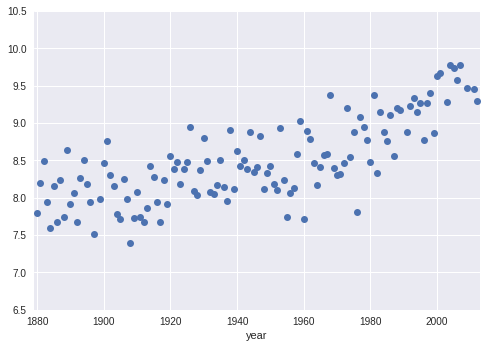

In [28]:
# Limpio los outliers
def mascara_outliers(s):
    return abs(s - s.mean()) <= 2*s.std()
    
mascara = mascara_outliers(df['temp'])
df = df[mascara]
sns.tsplot(time=df['year'], data=df['temp'], interpolate=False)

# Para que se evidencien mejor los outliers que saque, grafico en el mismo rango
# Algunos me parecen que no deberian ser removidos
sns.plt.ylim((6.5, 10.5))
sns.plt.show()

In [4]:
# Uso cuadrados minimos para predecir
sns.tsplot(time=df['year'], data=df['temp'], interpolate=False)

def armar_matriz_A(s):
    temp = []
    for t in s:
        temp.append([20*np.cos(5*t),1000*np.cos(60*t),10*np.sin(50*t),t, 1])
    return np.array(temp)

def entrenar_y_predecir_en_rangos(df, rango_entrenamiento, rango_prediccion):
    regr = linear_model.LinearRegression(fit_intercept=False)

    # Entreno el modelo
    df_e = df[df['year'].isin(rango_entrenamiento)]
    A_e = armar_matriz_A(df_e['year'])
    regr.fit(A_e, df_e['temp'])

    # Me fijo la aproximacion que se realizo
    df_e['p'] = regr.predict(A_e)
    sns.tsplot(time=df_e['year'], data=df_e['p'], color='r')

    # Realizo predicciones
    df_p = df[df['year'].isin(rango_prediccion)]

    A_p = armar_matriz_A(df_p['year'])
    df_p['p'] = regr.predict(A_p)
    sns.tsplot(time=df_p['year'], data=df_p['p'], color='g')

    ECM = sum((df_p['p']-df_p['temp'])**2)
    return ECM

def predecir(k):
    return entrenar_y_predecir_en_rangos(df, range(k-35,k), range(k,k+10))

Error de prediccion: 0.76
Error de prediccion: 2.01
Error de prediccion: 0.53
Error promedio: 1.09917354141


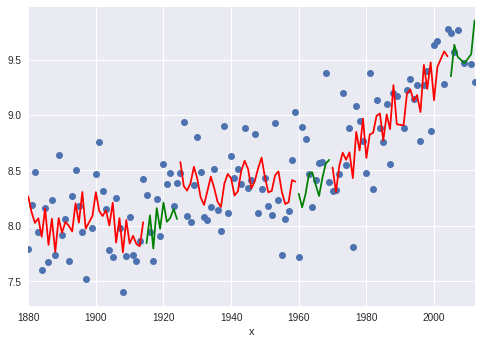

In [5]:

ECM1= predecir(1915)
print("Error de prediccion: {:.2f}".format(ECM1))    

ECM2= predecir(1960)
print("Error de prediccion: {:.2f}".format(ECM2))    

ECM3= predecir(2005)
print("Error de prediccion: {:.2f}".format(ECM3))

print ("Error promedio:",(ECM1+ECM2+ECM3)/3)

sns.plt.xlim((1880, 2012))
sns.plt.show()

In [6]:
# Un par de cosas mas de pandas
# years = [2004]*6 + [2005]*6 + [2006]*6
# delays = list(np.random.randn(6)+80) + list(np.random.randn(6)+5) + list(np.random.randn(6)+50)
# delays[2] = 5
# delays[7] = 80

# df1 = pd.DataFrame({
#     'year': years,
#     'delay': delays
# })

# print df1

# # Groupby y sacar outliers
# mascara = df1.groupby('year')['delay'].apply(mascara_outliers)
# df1 = df1[mascara]
# print df1

# # Groupby y calcular promedio
# promedio = df1.groupby('year').aggregate(['mean', 'std', 'count'])
# print promedio

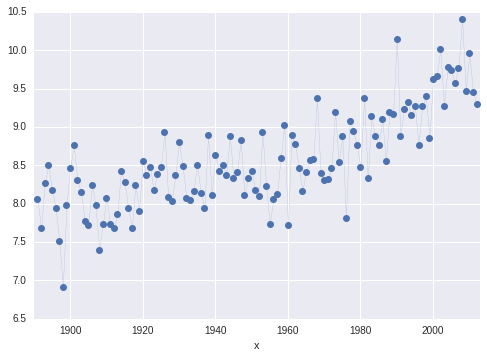

In [72]:
#Experimento 2 dirty version(?)
#Idea basica: 
#Elegir representantes caracteristicos de cada clima (porque dicho clima representa la mayor parte del pais)
#Ademas el pais intenta ser lo mas grande posible dentro del clima elegido. 

#Idea mejorada:
#Elegir varios representantes de cada clima y promediarlos obteniendo la tempertaura promedio anual de un clima dado.

# Para implementar idea mejorada:
# Por cada clima
#     Levantar el archivo de cada representante con el bucle definido abajo
#     Obtener promedio de cada país, de la misma manera que se hace ahora
#     Obtener promedio general del clima, de la misma manera que se hace ahora con los países
# Unir los dataframes y calcularles el promedio
# Agregar temperaturas del mundo

# Levanto los datos de cada pais, las mediciones son por mes
# Los años donde no hay mediciones no aparecen. Hay que hacer algo con esto despues...
## Como los años que no aparecen son los mismos para todos, yo tomaría a partir de 1891, que están todos
# Canada:

df_countries = pd.read_csv('./data/paises/Canada.csv',' ',header = None, names = ['year', 'Canada'])
df_countries['year'] = df_countries['year'].map(lambda x: int(math.modf(x)[1]))

# (Notar que este bucle vuelve a levantar Canada.csv)
# Repito para el resto
for filename in os.listdir('./data/paises/'):
    if filename != 'Canada.csv':
        aux = pd.read_csv('./data/paises/'+filename,' ',header = None, names = ['year', 'temp'])
        aux['year'] = aux['year'].map(lambda x: int(math.modf(x)[1]))
        df_countries[filename] = aux.temp

# Calculo el promedio anual de cada país
df = df_countries.groupby('year').mean()

# Necesario para que los años sean una key, y así poder manipularlos mejor (para plotear, por ej)
df = df.reset_index()
# Como los datos son consecutivos desde 1891, me quedo con ese subconjunto
df = (df[df['year'].isin(range(1891,2013))]).reset_index()

# Agrego la temperatura del planeta
df_world = pd.read_csv('./data/worldTemperature.csv',' ')
df_world = (df_world[df_world['x'].isin(range(1891,2013))]).reset_index()
df['worldAvg'] = df_world.y


#Ahora aplicar CM. 
#Funciones posibles(cada una de ellas es un experimento distinto, no necesariamente reportable (nos quedamos con el mejor): 
#Promedio asi nomas
#Promedio pesado
#Promedio pesado + cte
#mas...
#TODO

#Filtro outliers del dataframe dl mundo
def mascara_outliers(s):
    return abs(s - s.mean()) <= 2*s.std()
    
mascara = mascara_outliers(df_world['x'])
df_world = df_world[mascara]

#Graficos:
sns.tsplot(time=df_world['x'], data=df_world['y'], interpolate=False)

sns.plt.ylim((6.5, 10.5))
sns.plt.show()











In [ ]:
#Otros experimentos